In [ ]:
pip install alibi[tensorflow]

In [ ]:
pip install anomalib[full]

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict

import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

import tensorflow as tf
import tensorflow.keras as keras

from alibi.explainers import CounterfactualRL
from alibi.models.tensorflow import AE
from alibi.models.tensorflow import Actor, Critic
from alibi.explainers.cfrl_base import Callback

from pathlib import Path

from anomalib.data import PredictDataset
from anomalib.engine import Engine
from anomalib.models import Patchcore
import tempfile

from glob import glob
from PIL import Image

CATEGORY = "capsule"
BASE_DIR = os.getcwd()
CKPT_PATH = os.path.join(BASE_DIR, "results", "Patchcore", "MVTecAD", CATEGORY, "latest", "weights", "lightning", "model.ckpt")
IMAGE_SIZE = (256, 256)


In [151]:
TEMP_DIR = tempfile.gettempdir()
model = Patchcore()
engine =Engine()

def predictor(X: np.ndarray) -> np.ndarray:
    scores = []
    for i, x in enumerate(X):
        img_path = os.path.join(TEMP_DIR, f"img_{i}.png")
        img = Image.fromarray((x * 255).astype(np.uint8))
        img = img.resize(IMAGE_SIZE)
        img.save(img_path)
        dataset = PredictDataset(path=Path(img_path), image_size=IMAGE_SIZE)
        predictions = engine.predict(model=model, dataset=dataset, ckpt_path=CKPT_PATH)
        score = predictions[0].pred_score
        probs = np.array([1 - score, score]).flatten()  
        scores.append(probs)
        os.remove(img_path)
    result = np.array(scores) 
    return result

In [ ]:
def load_mvtec_images(path, size=(256, 256)):
    image_paths = glob(os.path.join(path, "*.png"))
    data = []
    for img_path in image_paths:
        img = Image.open(img_path).convert("RGB") 
        img = img.resize(size)
        img = np.array(img).astype(np.float32) / 255. 
        data.append(img)
    return np.array(data)

mvtec_root = os.path.join(BASE_DIR, "datasets", "MVTecAD", CATEGORY)
X_train = load_mvtec_images(os.path.join(mvtec_root, "train/good"))
X_test = load_mvtec_images(os.path.join(mvtec_root, "test/good"))
Y_test = load_mvtec_images(os.path.join(mvtec_root, "test/squeeze"))


In [153]:
BATCH_SIZE = 64
BUFFER_SIZE = 1024

trainset_ae = tf.data.Dataset.from_tensor_slices(X_train)
trainset_ae = trainset_ae.map(lambda x: (x, x))
trainset_ae = trainset_ae.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

testset_ae = tf.data.Dataset.from_tensor_slices(X_test)
testset_ae = testset_ae.map(lambda x: (x, x))
testset_ae = testset_ae.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

testset_ae = tf.data.Dataset.from_tensor_slices(Y_test)
testset_ae = testset_ae.map(lambda x: (x, x))
testset_ae = testset_ae.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


In [ ]:
def AnomalyEncoder(latent_dim):
    return keras.Sequential([
        keras.layers.Input(shape=(256, 256, 3)),
        keras.layers.Conv2D(32, 4, strides=2, padding='same', activation='relu'),
        keras.layers.Conv2D(64, 4, strides=2, padding='same', activation='relu'),
        keras.layers.Conv2D(128, 4, strides=2, padding='same', activation='relu'),
        keras.layers.Conv2D(256, 4, strides=2, padding='same', activation='relu'),
        keras.layers.Conv2D(512, 4, strides=2, padding='same', activation='relu'),
        keras.layers.Flatten(),
        keras.layers.Dense(latent_dim),
    ])

def AnomalyDecoder(latent_dim):
    return keras.Sequential([
        keras.layers.Input(shape=(latent_dim,)),
        keras.layers.Dense(8*8*512),
        keras.layers.Reshape((8, 8, 512)),
        keras.layers.Conv2DTranspose(256, 4, strides=2, padding='same', activation='relu'),
        keras.layers.Conv2DTranspose(128, 4, strides=2, padding='same', activation='relu'),
        keras.layers.Conv2DTranspose(64, 4, strides=2, padding='same', activation='relu'),
        keras.layers.Conv2DTranspose(32, 4, strides=2, padding='same', activation='relu'),
        keras.layers.Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid'),
    ])


In [ ]:
ae_path = os.path.join("autoencoder", "capsule_1024_70")
if not os.path.exists(ae_path):
    os.makedirs(ae_path)

LATENT_DIM = 1024
EPOCHS = 70

ae = AE(encoder=AnomalyEncoder(LATENT_DIM), decoder=AnomalyDecoder(LATENT_DIM))

ae.compile(optimizer=keras.optimizers.Adam(1e-3),
           loss=keras.losses.MeanSquaredError())

if len(os.listdir(ae_path)) == 0:
    ae.fit(trainset_ae, epochs=EPOCHS)
    ae.save(ae_path)
else:
    ae = keras.models.load_model(ae_path)


Epoch 1/70
4/4 [==============================] - 15s 3s/step - loss: 0.0937
Epoch 2/70
4/4 [==============================] - 12s 3s/step - loss: 0.0930
Epoch 3/70
4/4 [==============================] - 11s 3s/step - loss: 0.0918
Epoch 4/70
4/4 [==============================] - 11s 3s/step - loss: 0.0870
Epoch 5/70
4/4 [==============================] - 12s 3s/step - loss: 0.0493
Epoch 6/70
4/4 [==============================] - 12s 3s/step - loss: 0.0330
Epoch 7/70
4/4 [==============================] - 11s 3s/step - loss: 0.0254
Epoch 8/70
4/4 [==============================] - 12s 3s/step - loss: 0.0171
Epoch 9/70
4/4 [==============================] - 11s 3s/step - loss: 0.0092
Epoch 10/70
4/4 [==============================] - 11s 3s/step - loss: 0.0064
Epoch 11/70
4/4 [==============================] - 12s 3s/step - loss: 0.0052
Epoch 12/70
4/4 [==============================] - 12s 3s/step - loss: 0.0044
Epoch 13/70
4/4 [==============================] - 12s 3s/step - loss: 0.

INFO:tensorflow:Assets written to: tensorflow_1024_70_capsule/anomaly_autoencoder/assets


INFO:tensorflow:Assets written to: tensorflow_1024_70_capsule/anomaly_autoencoder/assets


1/1 [==============================] - 0s 271ms/step


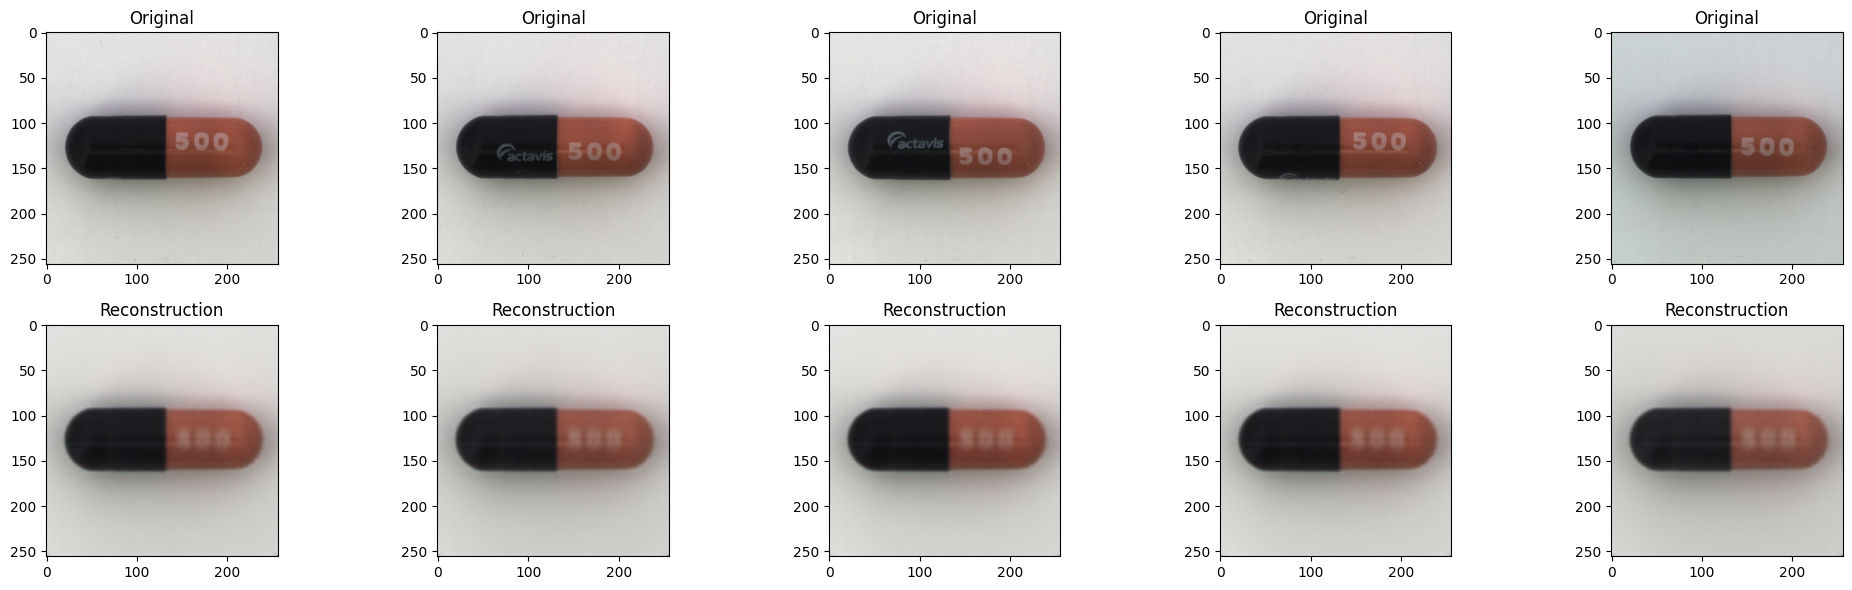

In [159]:
import matplotlib.pyplot as plt

num_samples = 5
samples = X_test[:num_samples]
recons = ae.predict(samples)

fig, ax = plt.subplots(2, num_samples, figsize=(20, 6))
for i in range(num_samples):
    ax[0, i].imshow(samples[i].squeeze())
    ax[0, i].set_title("Original")
    ax[1, i].imshow(recons[i].squeeze())
    ax[1, i].set_title("Reconstruction")
plt.tight_layout()
plt.show()


In [168]:
# Define constants
COEFF_SPARSITY = 7.5               # sparisty coefficient
COEFF_CONSISTENCY = 0              # consisteny coefficient -> no consistency
TRAIN_STEPS = 50                # number of training steps -> consider increasing the number of steps
BATCH_SIZE = 10                  # batch size

In [169]:
# Define explainer.
explainer = CounterfactualRL(predictor=predictor,
                             encoder=ae.encoder,
                             decoder=ae.decoder,
                             latent_dim=LATENT_DIM,
                             coeff_sparsity=COEFF_SPARSITY,
                             coeff_consistency=COEFF_CONSISTENCY,
                             train_steps=TRAIN_STEPS,
                             batch_size=BATCH_SIZE,
                             backend="tensorflow")

In [166]:
import logging

# Suppress warnings from anomalib.visualization
logging.getLogger("anomalib.visualization").setLevel(logging.ERROR)
# OR broader suppression for all anomalib logs
logging.getLogger("lightning_fabric").setLevel(logging.ERROR)
logging.getLogger().setLevel(logging.ERROR)

In [ ]:
explainer = explainer.fit(X=X_train)

In [ ]:
# Generate counterfactuals for some test instances.
explanation = explainer.explain(Y_test[0:10], Y_t=np.array([0]), batch_size=5)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

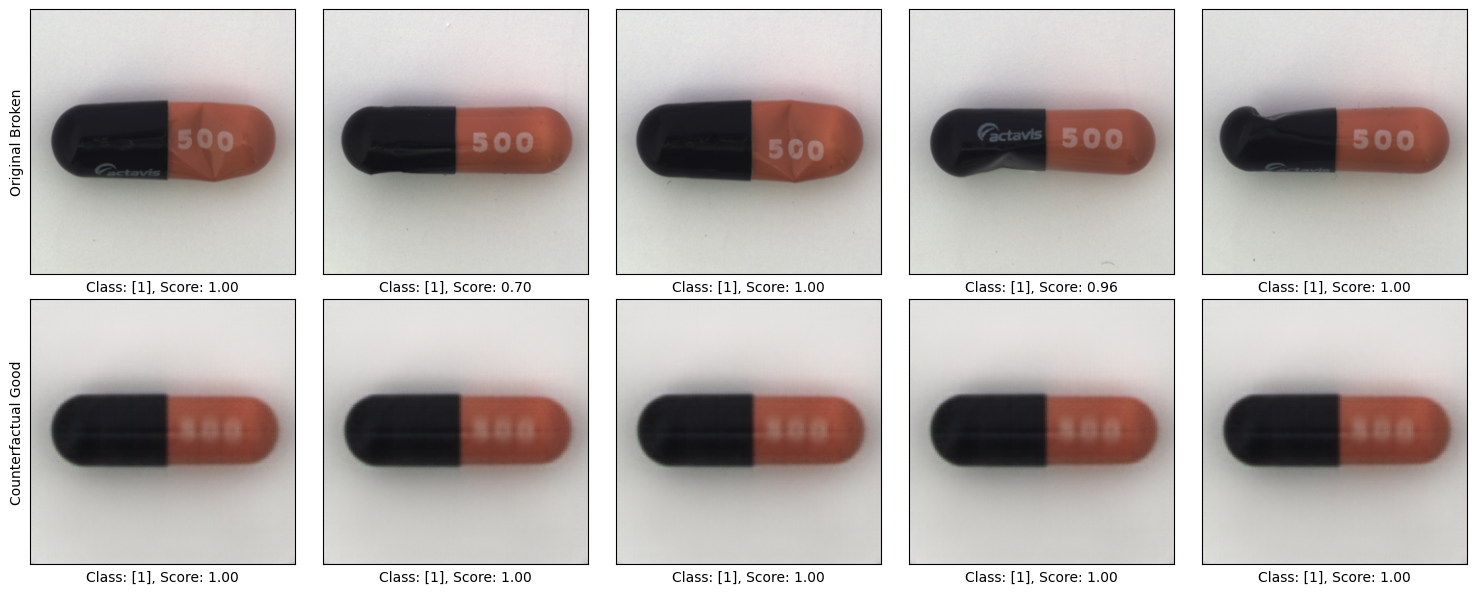

In [172]:
NUM_SAMPLES = 5
fig, ax = plt.subplots(2, NUM_SAMPLES, figsize=(NUM_SAMPLES*3, 6))

for i in range(NUM_SAMPLES):
    orig_probs = predictor(Y_test[0:NUM_SAMPLES])
    cf_probs = predictor(explanation.data['cf']['X'][0:NUM_SAMPLES])

    # Original broken bottle (RGB)
    ax[0][i].imshow(np.clip(explanation.data['orig']['X'][i], 0, 1))
    orig_score = orig_probs[i][1]  # Anomaly score
    orig_class = explanation.data['orig']['class'][i]
    ax[0][i].set_xlabel(f"Class: {orig_class}, Score: {orig_score:.2f}")
    ax[0][i].set_xticks([])
    ax[0][i].set_yticks([])

    # Counterfactual good bottle (RGB)
    ax[1][i].imshow(np.clip(explanation.data['cf']['X'][i], 0, 1))
    cf_score = cf_probs[i][1]
    cf_class = explanation.data['cf']['class'][i]
    ax[1][i].set_xlabel(f"Class: {cf_class}, Score: {cf_score:.2f}")
    ax[1][i].set_xticks([])
    ax[1][i].set_yticks([])

ax[0][0].set_ylabel("Original Broken")
ax[1][0].set_ylabel("Counterfactual Good")

plt.tight_layout()
plt.show()